<a href="https://colab.research.google.com/github/lbuerger/IANNwTF/blob/main/homework4/hw4_201120.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
ds = tfds.load('malaria')
ds = ds['train']
ds

Shuffling and writing examples to /root/tensorflow_datasets/malaria/1.0.0.incompleteLXKXG2/malaria-train.tfrecord


Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


<PrefetchDataset shapes: {image: (None, None, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>

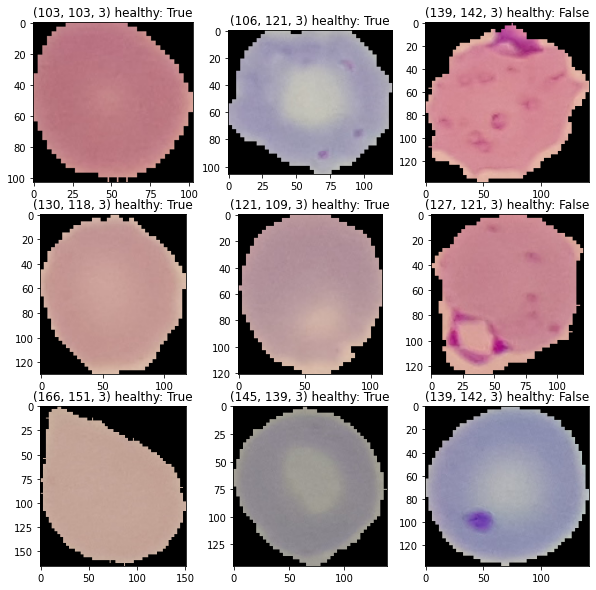

In [3]:
count = 0
fig = plt.figure(figsize=(10,10))
for img in ds:
  count += 1
  fig.add_subplot(3,3,count)
  #print(img['label'].numpy())
  plt.imshow(img['image'])
  plt.title(str(img['image'].shape) + " healthy: " + str(bool(img['label'].numpy())))
  if count == 9:
    break;
fig.show()

In [4]:
def preprocess_img(image):
  image = tf.image.resize(image,[128,128])
  image /= tf.math.reduce_max(image)
  return image

In [5]:
ds_map = ds.map(lambda x : (preprocess_img(x['image']), tf.one_hot(x['label'],2)))
ds_map # 128x128x3 0-1 floats and onehot (True False = malaria; False True = healthy)

<MapDataset shapes: ((128, 128, 3), (2,)), types: (tf.float32, tf.float32)>

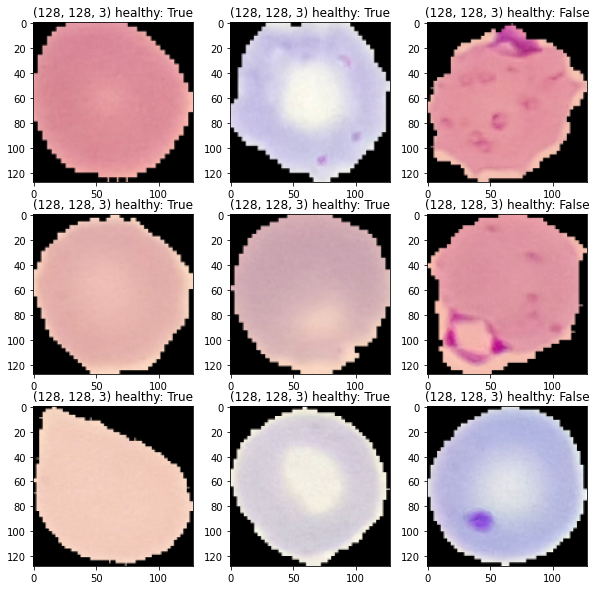

In [6]:
count = 0
fig = plt.figure(figsize=(10,10))
for img in ds_map:
  count += 1
  fig.add_subplot(3,3,count)
  #print(img[0].numpy())
  plt.imshow(img[0])
  plt.title(str(img[0].shape) + " healthy: " + str(bool(img[1][1].numpy())))
  if count == 9:
    break;
fig.show()

In [7]:
train_ds = ds_map.skip(1000).batch(64).shuffle(buffer_size=64).prefetch(4)
test_ds = ds_map.take(1000).batch(64).shuffle(buffer_size=64).prefetch(4)

In [8]:
for (img,_) in test_ds:
    print(img.shape)
    break;

(64, 128, 128, 3)


In [9]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        # Define the three layers.
        self.conv_1 = tf.keras.layers.Conv2D(filters=16, kernel_size=3,
                                               activation=tf.keras.activations.relu,
                                               input_shape=(128,128,3)
                                               )
        self.max_pool_1 = tf.keras.layers.MaxPool2D(pool_size=4)
        self.conv_2 = tf.keras.layers.Conv2D(filters=16, kernel_size=3,
                                               activation=tf.keras.activations.relu,
                                               )
        self.max_pool_2 = tf.keras.layers.MaxPool2D(pool_size=4)

        self.conv_3 = tf.keras.layers.Conv2D(filters=32, kernel_size=3,
                                               activation=tf.keras.activations.relu,
                                                )
        self.max_pool_3 = tf.keras.layers.MaxPool2D(4)

        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()

        self.output_layer = tf.keras.layers.Dense(2,
                                                  activation=tf.keras.activations.softmax)


    def call(self, x):
        # Define the forward step.
        x = self.conv_1(x)
        x = self.max_pool_1(x)
        x = self.conv_2(x)
        x = self.max_pool_2(x)
        x = self.conv_3(x)
        x = self.max_pool_3(x)
        x = self.global_pool(x)
        x = self.output_layer(x)
        return x

In [10]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy
  

In [11]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 20
learning_rate = 0.0001
running_average_factor = 0.95

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)
print("Pre-learning")
print('test loss:', test_loss, 'acc:', test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_ds, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_ds = train_ds.shuffle(buffer_size=128)
    test_ds = test_ds.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_ds:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print('test loss:', test_loss, 'acc:', test_accuracy)


Pre-learning
test loss: 0.69502115 acc: 0.509375
Epoch: __ 0
test loss: 0.6660485 acc: 0.637109375
Epoch: __ 1
test loss: 0.5452309 acc: 0.7501953125
Epoch: __ 2
test loss: 0.416875 acc: 0.8458984375
Epoch: __ 3
test loss: 0.3617358 acc: 0.8673828125
Epoch: __ 4
test loss: 0.3281466 acc: 0.8806640625
Epoch: __ 5
test loss: 0.28974637 acc: 0.8884765625
Epoch: __ 6
test loss: 0.26401758 acc: 0.90078125
Epoch: __ 7
test loss: 0.24708231 acc: 0.9076171875
Epoch: __ 8
test loss: 0.23998165 acc: 0.9140625
Epoch: __ 9
test loss: 0.23246509 acc: 0.9125
Epoch: __ 10
test loss: 0.22267902 acc: 0.918359375
Epoch: __ 11
test loss: 0.21842104 acc: 0.9203125
Epoch: __ 12
test loss: 0.21736461 acc: 0.9173828125
Epoch: __ 13
test loss: 0.22362445 acc: 0.9208984375
Epoch: __ 14
test loss: 0.21198069 acc: 0.9189453125
Epoch: __ 15
test loss: 0.2099692 acc: 0.9212890625
Epoch: __ 16
test loss: 0.2028909 acc: 0.926171875
Epoch: __ 17
test loss: 0.19954944 acc: 0.9251953125
Epoch: __ 18
test loss: 0.200236

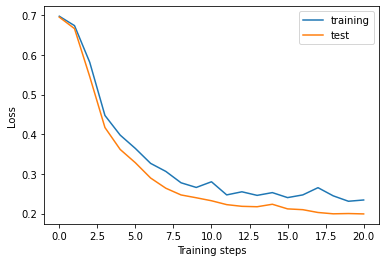

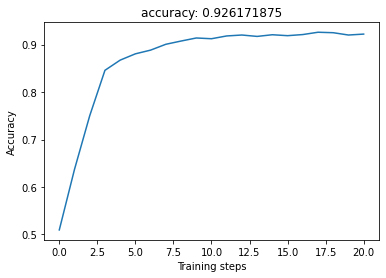

In [12]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.title('accuracy: '+ str(np.max(test_accuracies)))
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()